<a href="https://colab.research.google.com/github/ivanpalenciab/prediccion-precio-maiz/blob/Comparativa/XG_boost_EMD_anual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [3]:
modo_1 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_1.csv")
modo_2 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_2.csv")
modo_3 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_3.csv")
modo_4 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_4.csv")
modo_5 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_5.csv")
residuo = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/residuo.csv")
modos = [modo_1,modo_2,modo_3,modo_4,modo_5,residuo]

for i in modos:
  i["Fecha"] = pd.to_datetime(i["Fecha"],format='%Y-%m-%d')
  i.set_index("Fecha", inplace=True)

#modo_1["Fecha"] = pd.to_datetime(modo_1["Fecha"],format='%Y-%m-%d')
#modo_1.set_index("Fecha", inplace=True)

<Axes: xlabel='Fecha'>

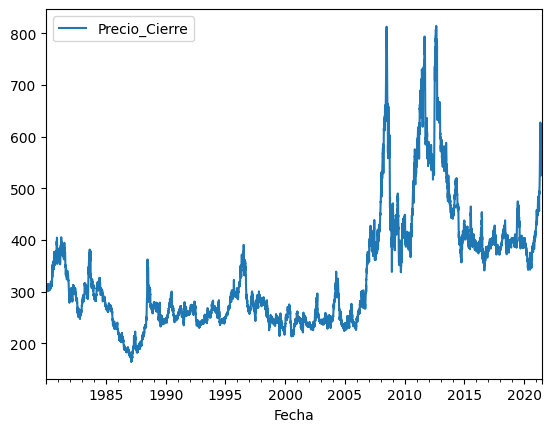

In [4]:
datos_emd = modo_1 + modo_2 + modo_3 + modo_4 + modo_5 + residuo
datos_emd = datos_emd.asfreq('D')
datos_emd.interpolate(inplace=True)
datos_emd.plot()

In [5]:
modo_1.shape

(10454, 1)

In [6]:
def  create_features ( df ):
    """
    Crea características de series de tiempo basadas en el índice de series de tiempo.
    """
    df = df.copy()
    df[ 'diasemana' ] = df.index.dayofweek
    df[ 'trimestre' ] = df.index.quarter
    df[ 'mes' ] = df.index.month
    df[ 'año' ] = df.index.year
    df[ 'diadelaño' ] = df.index.dayofyear
    df[ 'diadelmes' ] = df.index.day
    df[ 'semanadelaño' ] = df.index.isocalendar().week
    return df

def add_lags(df):
    target_map = df['Precio_Cierre'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('730 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1095 days')).map(target_map)
    return df


In [7]:
def ajuste_modelo(datos_entrenamiento, datos_validacion):

  learning_rate = [0.01, 0.1, 0.2]
  max_depth = [2,3, 4, 5,6,7,8]
  subsample = [0.8, 0.9, 1.0]
  colsample_bytree = [0.7,0.8, 0.9, 1.0]

  errores_learning_rate = []
  errores_max_depth = {"i":{"j":[]}}
  errores = []

  CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
  X_train = datos_entrenamiento[CARACTERISTICAS]
  y_train = datos_entrenamiento.Precio_Cierre

  X_test = datos_validacion[CARACTERISTICAS]
  y_test = datos_validacion.Precio_Cierre

  for i in learning_rate:
    for j in max_depth:
     for k in subsample:
        reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            max_depth= j ,
                            learning_rate= i )


        reg.fit(X_train, y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=0)
        y_predict = reg.predict(datos_validacion[CARACTERISTICAS])
        y_predict = pd.Series(y_predict)

        score = mean_absolute_error(y_predict,datos_validacion.Precio_Cierre)
      #score = np.sqrt(mean_squared_error(y_predict,datos_validacion.Precio_Cierre))

        errores.append((i,j,k,score))

        indice, valor_minimo = min(enumerate(errores), key=lambda x: x[1][3])

  print("El número más pequeño en la posición 3 de las tuplas es:", valor_minimo[3])
  print("El índice de la tupla con el número más pequeño es:", indice)
  print( f"el learning rate es {errores[indice][0]} el max_depth es {errores[indice][1]} y el subsample es {errores[indice][2]}")

In [8]:
def modelo(datos_entrenamiento,datos_validacion,learning_rate,max_depth,subsample):

  CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
  X_train = datos_entrenamiento[CARACTERISTICAS]
  y_train = datos_entrenamiento.Precio_Cierre

  X_validacion = datos_validacion[CARACTERISTICAS]
  y_validacion = datos_validacion.Precio_Cierre

  reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=subsample,
                            max_depth= max_depth ,
                            learning_rate= learning_rate )


  reg.fit(X_train, y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=0)

  validacion = reg.predict(X_validacion)
  validacion = pd.Series(validacion)
  recm = np.sqrt(mean_squared_error(validacion,y_validacion))
  mae = mean_absolute_error(validacion,y_validacion)
  mape = mean_absolute_percentage_error(validacion,y_validacion)

  #imprimir puntuaciones para cada pliegue
  print ( f'La raiz del error cuadratico medio es : {recm} ' )
  print(f"Error Absoluto medio es {mae}")
  print(f"porcentaje de error absoluto medio es :  {mape}")
  return reg , validacion

In [9]:
CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]

# Modelaremos el primer modo

In [10]:
modo_1 = modo_1.asfreq('D')
modo_1.interpolate(inplace=True)

In [11]:
modo_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15155 entries, 1980-01-02 to 2021-06-29
Freq: D
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Precio_Cierre  15155 non-null  float64
dtypes: float64(1)
memory usage: 236.8 KB


In [12]:
modo_1_values = modo_1.values
modo_1_values = modo_1_values.astype('float32')
modo_1_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_1_values = modo_1_values.reshape(-1, 1)
modo_1_escalado =  pd.DataFrame(modo_1_scaler.fit_transform(modo_1_values), columns=modo_1.columns,index=modo_1.index)
modo_1_escalado.head()

,Precio_Cierre
Fecha,
1980-01-02,-0.111422
1980-01-03,0.026287
1980-01-04,0.153734
1980-01-05,0.119612
1980-01-06,0.085490


In [13]:
modo_1_sup = create_features(modo_1_escalado)
modo_1_sup = add_lags(modo_1_sup)
modo_1_sup.dropna(inplace=True)
modo_1_sup.tail()

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
2021-06-25,-0.287204,4,2,6,2021,176,25,25,-0.117220,0.074994,0.038639
2021-06-26,-0.068949,5,2,6,2021,177,26,25,-0.302189,0.129654,0.065475
2021-06-27,0.149307,6,2,6,2021,178,27,25,-0.274386,-0.108590,-0.101332
2021-06-28,0.367562,0,2,6,2021,179,28,26,-0.246583,-0.147201,0.097278
2021-06-29,-0.374720,1,2,6,2021,180,29,26,-0.218779,-0.185812,0.032003


In [14]:
modo_1= pd.DataFrame(modo_1_scaler.inverse_transform(modo_1_sup),columns=modo_1_sup.columns,index=modo_1_sup.index)

In [15]:
total_datos=len(modo_1_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m1 = modo_1_sup[:division_entrenamiento]
datos_validacion_m1 = modo_1_sup[division_entrenamiento:division_validacion]
datos_testeo_m1 = modo_1_sup[division_validacion:total_datos]

In [16]:
total_datos=len(modo_1_sup.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = modo_1_sup[:division_entrenamiento]
datos_validacion = modo_1_sup[division_entrenamiento:division_validacion]
datos_testeo = modo_1_sup[division_validacion:total_datos]

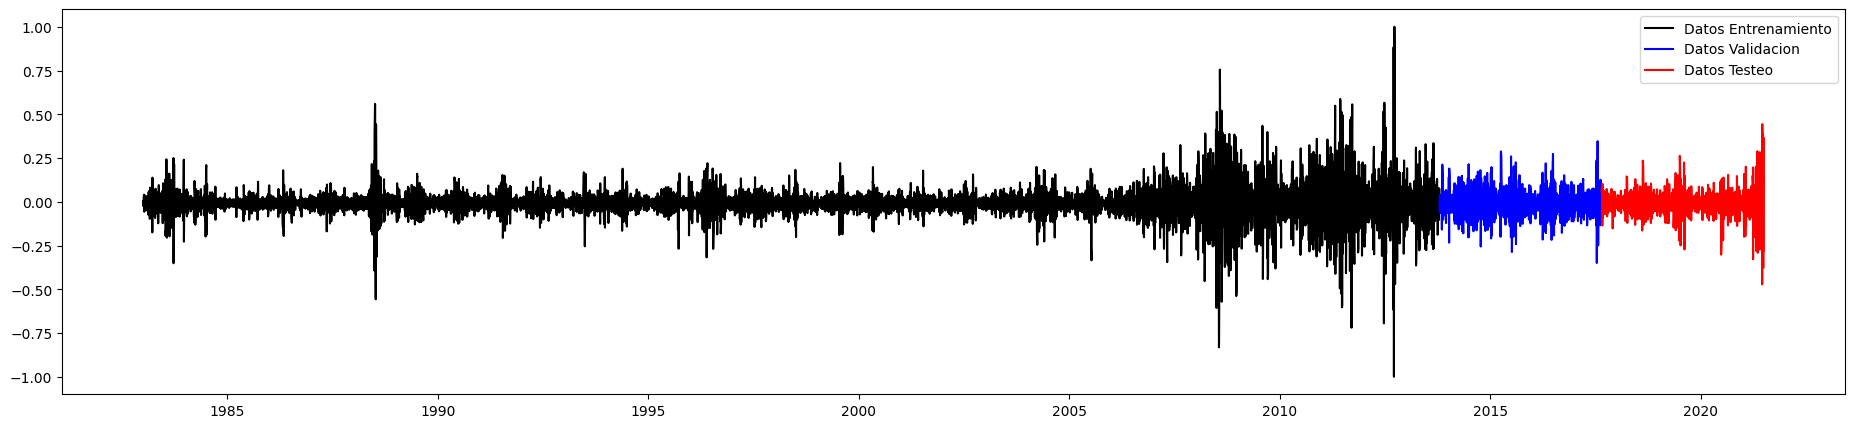

In [17]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [18]:
learning_rate = [0.01, 0.1, 0.2]
max_depth = [2,3, 4, 5,6,7,8]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.7,0.8, 0.9, 1.0]

errores_learning_rate = []
errores_max_depth = {"i":{"j":[]}}
errores = []

X_train = datos_entrenamiento_m1[CARACTERISTICAS]
y_train =  datos_entrenamiento_m1.Precio_Cierre

X_test = datos_validacion_m1[CARACTERISTICAS]
y_test = datos_validacion_m1.Precio_Cierre

for i in learning_rate:
  for j in max_depth:
    for k in subsample:
      reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            max_depth= j ,
                            learning_rate= i )


      reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=0)
      y_predict = reg.predict(datos_validacion_m1[CARACTERISTICAS])
      y_predict = pd.Series(y_predict)

      #score = mean_absolute_percentage_error(y_predict,datos_validacion_m2.Precio_Cierre)
      score = np.sqrt(mean_squared_error(y_predict,datos_validacion_m1.Precio_Cierre))

      errores.append((i,j,k,score))

In [19]:
indice, valor_minimo = min(enumerate(errores), key=lambda x: x[1][3])

print("El número más pequeño en la posición 3 de las tuplas es:", valor_minimo[3])
print("El índice de la tupla con el número más pequeño es:", indice)
print( f"el learning rate es {errores[indice][0]} el max_depth es {errores[indice][1]} y el subsample es {errores[indice][2]}")

El número más pequeño en la posición 3 de las tuplas es: 0.07796848
El índice de la tupla con el número más pequeño es: 2
el learning rate es 0.01 el max_depth es 2 y el subsample es 1.0


In [20]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
modo_1_sup = modo_1_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_1_sup[:division_validacion]) :
    train = modo_1_sup.iloc[train_idx]
    test = modo_1_sup.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 2 ,
                           learning_rate= 0.2,
                            subsample=0.8)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_modo_1 = reg.predict(X_test)
    validacion_modo_1 = pd.Series(validacion_modo_1)
    preds.append(validacion_modo_1)
    score = np.sqrt(mean_squared_error(validacion_modo_1,y_test))
    mae = mean_absolute_error(validacion_modo_1,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_1,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)

validacion_modo_1 = reg.predict(datos_validacion[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:0.08958	validation_1-rmse:0.09279
[49]	validation_0-rmse:0.08743	validation_1-rmse:0.09483
[0]	validation_0-rmse:0.08969	validation_1-rmse:0.07109
[50]	validation_0-rmse:0.08785	validation_1-rmse:0.07375
[0]	validation_0-rmse:0.08920	validation_1-rmse:0.06914
[55]	validation_0-rmse:0.08716	validation_1-rmse:0.06979
Puntuación entre pliegues 0.07766059041023254 
Puntuaciones plegar: [0.0927905, 0.071085274, 0.069106] 
Error Absoluto medio entre pliegues 0.05866120755672455
porcentaje de error absoluto medio entre pliegues 8.838068962097168


In [21]:


X_train=modo_1_sup[CARACTERISTICAS][:division_validacion]
y_train = modo_1_sup[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


prediccion_modo_1 = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],prediccion_modo_1))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:0.08868	validation_1-rmse:0.06914
[100]	validation_0-rmse:0.08586	validation_1-rmse:0.06880
[186]	validation_0-rmse:0.08466	validation_1-rmse:0.06873
El error Cuadratico medio del modelo es 0.0774000808596611


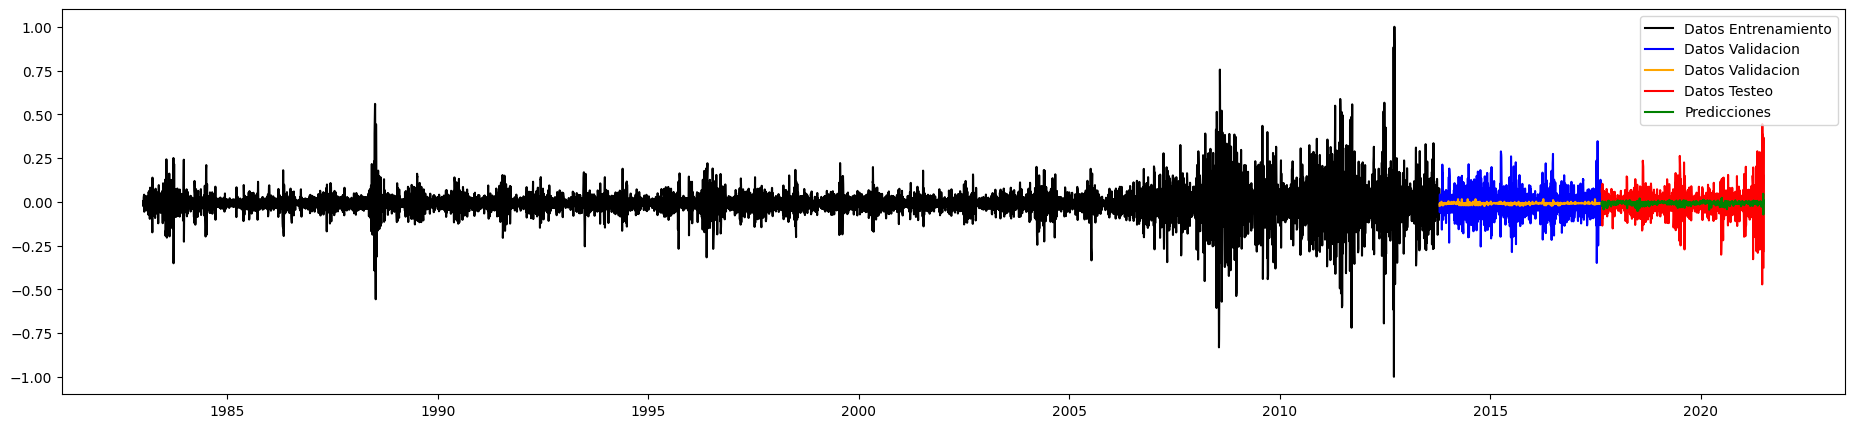

In [22]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion.index,validacion_modo_1,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,prediccion_modo_1,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [23]:
validacion_modo_1 = modo_1_scaler.inverse_transform(validacion_modo_1.reshape(-1, 1))
prediccion_modo_1 = modo_1_scaler.inverse_transform(prediccion_modo_1.reshape(-1, 1))

In [24]:
validacion_modo_1

array([[-0.5226649 ],
       [-0.02714732],
       [-0.02714732],
       ...,
       [-0.02714732],
       [-0.02714732],
       [-0.02714732]], dtype=float32)

# Modelaremos el segundo modo

In [25]:
modo_2 = modo_2.asfreq('D')
modo_2.interpolate(inplace=True)

In [26]:
modo_2.shape

(15155, 1)

In [27]:
modo_2_values = modo_2.values
modo_2_values = modo_2_values.astype('float32')
modo_2_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_2_values = modo_2_values.reshape(-1, 1)
modo_2_escalado =  pd.DataFrame(modo_2_scaler.fit_transform(modo_2_values), columns=modo_2.columns,index=modo_2.index)
modo_2_escalado.head()

,Precio_Cierre
Fecha,
1980-01-02,0.307612
1980-01-03,0.237516
1980-01-04,0.166993
1980-01-05,0.154927
1980-01-06,0.142860


In [28]:
modo_2_sup = create_features(modo_2_escalado)
modo_2_sup = add_lags(modo_2_sup)
modo_2_sup.dropna(inplace=True)
modo_2_sup.tail()

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
2021-06-25,0.098505,4,2,6,2021,176,25,25,0.003145,0.214015,0.187040
2021-06-26,0.137916,5,2,6,2021,177,26,25,0.044860,0.133316,0.186622
2021-06-27,0.177327,6,2,6,2021,178,27,25,0.084846,0.039971,0.207474
2021-06-28,0.216738,0,2,6,2021,179,28,26,0.124831,0.013771,0.188727
2021-06-29,0.224942,1,2,6,2021,180,29,26,0.164817,-0.012429,0.166583


In [29]:
modo_2= pd.DataFrame(modo_2_scaler.inverse_transform(modo_2_sup),columns=modo_2_sup.columns,index=modo_2_sup.index)

In [30]:
total_datos=len(modo_2_sup.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = modo_2_sup[:division_entrenamiento]
datos_validacion = modo_2_sup[division_entrenamiento:division_validacion]
datos_testeo = modo_2_sup[division_validacion:total_datos]

In [31]:
total_datos=len(modo_2_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m2 = modo_2_sup[:division_entrenamiento]
datos_validacion_m2 = modo_2_sup[division_entrenamiento:division_validacion]
datos_testeo_m2 = modo_2_sup[division_validacion:total_datos]

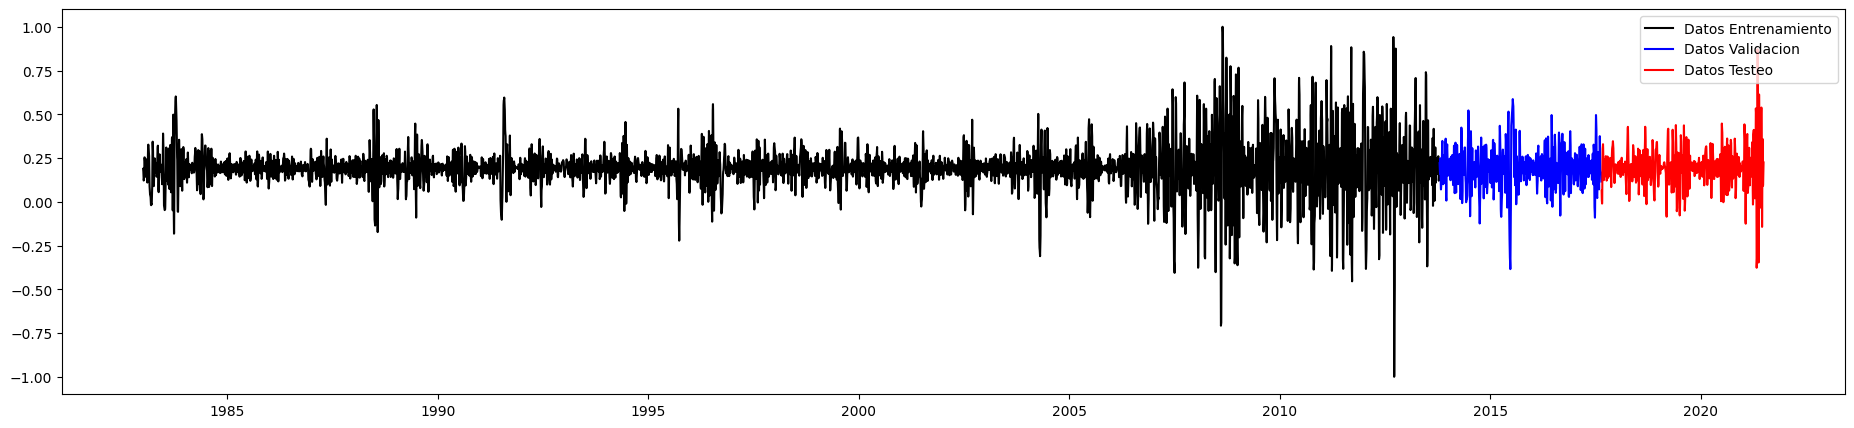

In [32]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [33]:
learning_rate = [0.01, 0.1, 0.2]
max_depth = [2,3, 4, 5,6,7,8]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.7,0.8, 0.9, 1.0]

errores_learning_rate = []
errores_max_depth = {"i":{"j":[]}}
errores = []

X_train = datos_entrenamiento_m2[CARACTERISTICAS]
y_train =  datos_entrenamiento_m2.Precio_Cierre

X_test = datos_validacion_m2[CARACTERISTICAS]
y_test = datos_validacion_m2.Precio_Cierre

for i in learning_rate:
  for j in max_depth:
    for k in subsample:
      reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            max_depth= j ,
                            learning_rate= i )


      reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=0)
      y_predict = reg.predict(datos_validacion_m1[CARACTERISTICAS])
      y_predict = pd.Series(y_predict)

      #score = mean_absolute_percentage_error(y_predict,datos_validacion_m2.Precio_Cierre)
      score = np.sqrt(mean_squared_error(y_predict,datos_validacion_m2.Precio_Cierre))

      errores.append((i,j,k,score))

In [34]:
indice, valor_minimo = min(enumerate(errores), key=lambda x: x[1][3])

print("El número más pequeño en la posición 3 de las tuplas es:", valor_minimo[3])
print("El índice de la tupla con el número más pequeño es:", indice)
print( f"el learning rate es {errores[indice][0]} el max_depth es {errores[indice][1]} y el subsample es {errores[indice][2]}")

El número más pequeño en la posición 3 de las tuplas es: 0.11715132
El índice de la tupla con el número más pequeño es: 42
el learning rate es 0.2 el max_depth es 2 y el subsample es 0.8


In [35]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
modo_2_sup = modo_2_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_2_sup[:division_validacion]) :
    train = modo_2_sup.iloc[train_idx]
    test = modo_2_sup.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 2 ,
                           learning_rate= 0.2,
                            subsample=0.8)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_modo_2 = reg.predict(X_test)
    validacion_modo_2 = pd.Series(validacion_modo_2)
    preds.append(validacion_modo_2)
    score = np.sqrt(mean_squared_error(validacion_modo_2,y_test))
    mae = mean_absolute_error(validacion_modo_2,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_2,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)

validacion_modo_2 = reg.predict(datos_validacion[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:0.12953	validation_1-rmse:0.16380
[50]	validation_0-rmse:0.12384	validation_1-rmse:0.17331
[0]	validation_0-rmse:0.13072	validation_1-rmse:0.08652
[56]	validation_0-rmse:0.12525	validation_1-rmse:0.09060
[0]	validation_0-rmse:0.12964	validation_1-rmse:0.09774
[65]	validation_0-rmse:0.12386	validation_1-rmse:0.10105
Puntuación entre pliegues 0.1152745857834816 
Puntuaciones plegar: [0.16380334, 0.085812606, 0.09620783] 
Error Absoluto medio entre pliegues 0.08502926677465439
porcentaje de error absoluto medio entre pliegues 0.4432539939880371


In [36]:
X_train=modo_2_sup[CARACTERISTICAS][:division_validacion]
y_train = modo_2_sup[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


prediccion_modo_2 = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],prediccion_modo_2))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:0.12881	validation_1-rmse:0.09741
[82]	validation_0-rmse:0.12256	validation_1-rmse:0.09706
El error Cuadratico medio del modelo es 0.11461170762777328


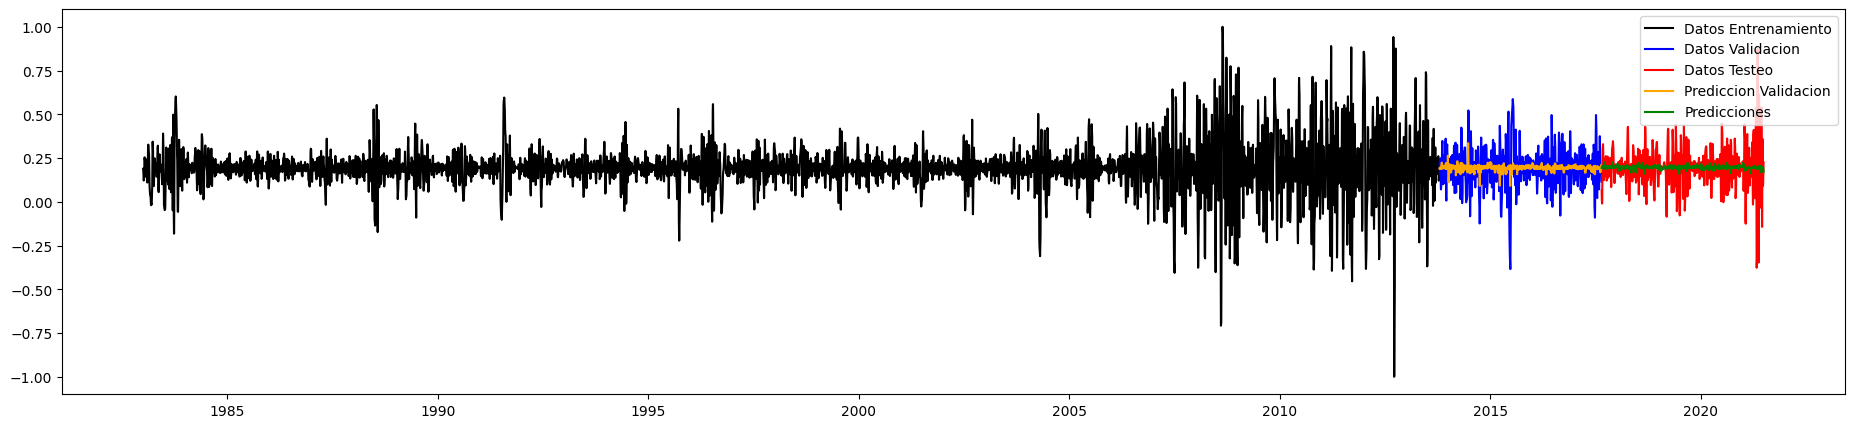

In [37]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion.index,validacion_modo_2,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo.index,prediccion_modo_2,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [38]:
validacion_modo_2 = modo_2_scaler.inverse_transform(validacion_modo_2.reshape(-1, 1))
prediccion_modo_2 = modo_2_scaler.inverse_transform(prediccion_modo_2.reshape(-1, 1))

# Modelaremos el 3 modo

In [39]:
modo_3 = modo_3.asfreq('D')
modo_3.interpolate(inplace=True)

In [40]:
modo_3_values = modo_3.values
modo_3_values = modo_3_values.astype('float32')
modo_3_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_3_values = modo_3_values.reshape(-1, 1)
modo_3_escalado =  pd.DataFrame(modo_3_scaler.fit_transform(modo_3_values), columns=modo_3.columns,index=modo_3.index)
modo_3_escalado.head()

,Precio_Cierre
Fecha,
1980-01-02,0.151156
1980-01-03,0.128091
1980-01-04,0.106627
1980-01-05,0.102951
1980-01-06,0.099274


In [41]:
modo_3_sup = create_features(modo_3_escalado)
modo_3_sup = add_lags(modo_3_sup)
modo_3_sup.dropna(inplace=True)
modo_3_sup.tail()

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
2021-06-25,-0.375345,4,2,6,2021,176,25,25,0.060023,0.054003,-0.153403
2021-06-26,-0.377668,5,2,6,2021,177,26,25,0.078545,0.032859,-0.154597
2021-06-27,-0.379991,6,2,6,2021,178,27,25,0.085968,0.017336,-0.155277
2021-06-28,-0.382314,0,2,6,2021,179,28,26,0.093391,0.014720,-0.155054
2021-06-29,-0.378230,1,2,6,2021,180,29,26,0.100814,0.012105,-0.154919


In [42]:
modo_3= pd.DataFrame(modo_3_scaler.inverse_transform(modo_3_sup),columns=modo_3_sup.columns,index=modo_3_sup.index)

In [43]:
total_datos=len(modo_3_sup.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = modo_3_sup[:division_entrenamiento]
datos_validacion = modo_3_sup[division_entrenamiento:division_validacion]
datos_testeo = modo_3_sup[division_validacion:total_datos]

In [44]:
total_datos=len(modo_3_sup.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m3 = modo_3_sup[:division_entrenamiento]
datos_validacion_m3 = modo_3_sup[division_entrenamiento:division_validacion]
datos_testeo_m3 = modo_3_sup[division_validacion:total_datos]

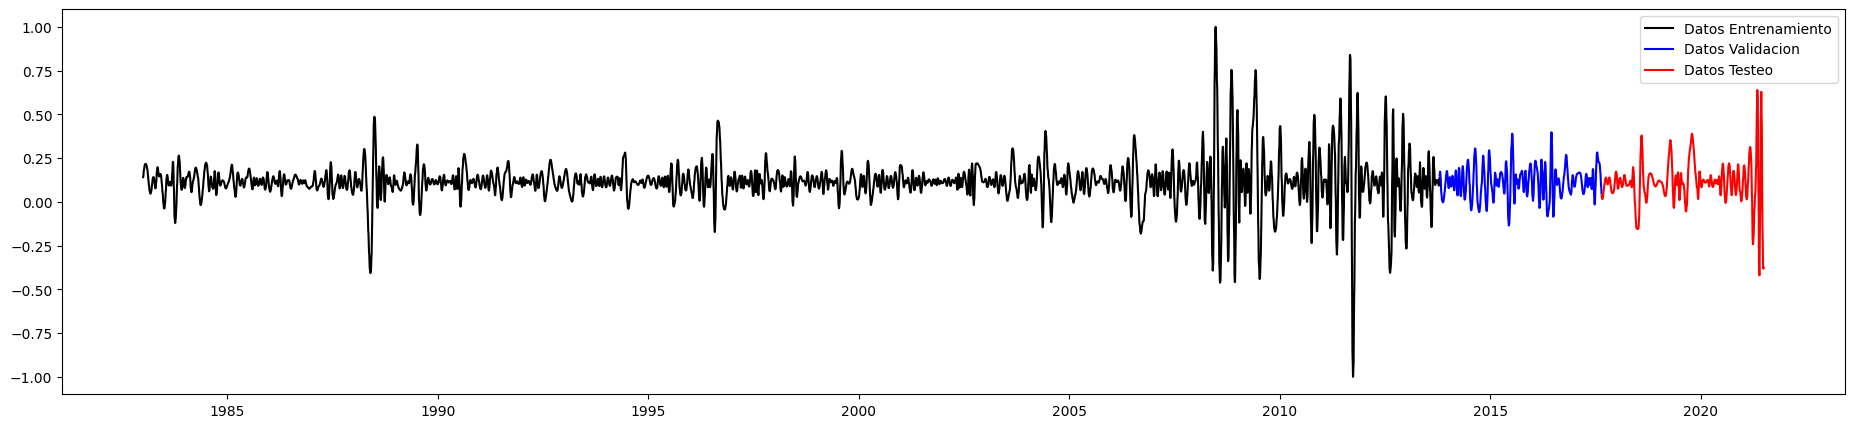

In [45]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [46]:
learning_rate = [0.01, 0.1, 0.2]
max_depth = [2,3, 4, 5,6,7,8]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.7,0.8, 0.9, 1.0]

errores_learning_rate = []
errores_max_depth = {"i":{"j":[]}}
errores = []

X_train = datos_entrenamiento_m3[CARACTERISTICAS]
y_train =  datos_entrenamiento_m3.Precio_Cierre

X_test = datos_validacion_m3[CARACTERISTICAS]
y_test = datos_validacion_m3.Precio_Cierre

for i in learning_rate:
  for j in max_depth:
    for k in subsample:
      reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            max_depth= j ,
                            learning_rate= i )


      reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=0)
      y_predict = reg.predict(datos_validacion_m1[CARACTERISTICAS])
      y_predict = pd.Series(y_predict)

      #score = mean_absolute_percentage_error(y_predict,datos_validacion_m2.Precio_Cierre)
      score = np.sqrt(mean_squared_error(y_predict,datos_validacion_m3.Precio_Cierre))

      errores.append((i,j,k,score))

In [47]:
indice, valor_minimo = min(enumerate(errores), key=lambda x: x[1][3])

print("El número más pequeño en la posición 3 de las tuplas es:", valor_minimo[3])
print("El índice de la tupla con el número más pequeño es:", indice)
print( f"el learning rate es {errores[indice][0]} el max_depth es {errores[indice][1]} y el subsample es {errores[indice][2]}")

El número más pequeño en la posición 3 de las tuplas es: 0.087598726
El índice de la tupla con el número más pequeño es: 12
el learning rate es 0.01 el max_depth es 6 y el subsample es 0.8


In [48]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
modo_3_sup = modo_3_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_3[:division_validacion]) :
    train = modo_3_sup.iloc[train_idx]
    test = modo_3_sup.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                          # Objective= 'reg:squarederror' ,
                           max_depth= 2 ,
                           learning_rate= 0.2,
                            subsample=0.8)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_modo_3 = reg.predict(X_test)
    validacion_modo_3 = pd.Series(validacion_modo_3)
    preds.append(validacion_modo_3)
    score = np.sqrt(mean_squared_error(validacion_modo_3,y_test))
    mae = mean_absolute_error(validacion_modo_3,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_3,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_3 = reg.predict(datos_validacion[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:0.12350	validation_1-rmse:0.11662
[51]	validation_0-rmse:0.11353	validation_1-rmse:0.15685
[0]	validation_0-rmse:0.12296	validation_1-rmse:0.09423
[49]	validation_0-rmse:0.11384	validation_1-rmse:0.10278
[0]	validation_0-rmse:0.12224	validation_1-rmse:0.06656
[52]	validation_0-rmse:0.11348	validation_1-rmse:0.07544
Puntuación entre pliegues 0.09214059263467789 
Puntuaciones plegar: [0.115742736, 0.094232656, 0.066446394] 
Error Absoluto medio entre pliegues 0.07245280593633652
porcentaje de error absoluto medio entre pliegues 0.6137756705284119


In [49]:
X_train=modo_3_sup[CARACTERISTICAS][:division_validacion]
y_train = modo_3_sup[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


prediccion_modo_3 = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],prediccion_modo_3))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:0.12099	validation_1-rmse:0.06651
[53]	validation_0-rmse:0.11242	validation_1-rmse:0.07171
El error Cuadratico medio del modelo es 0.12241602689027786


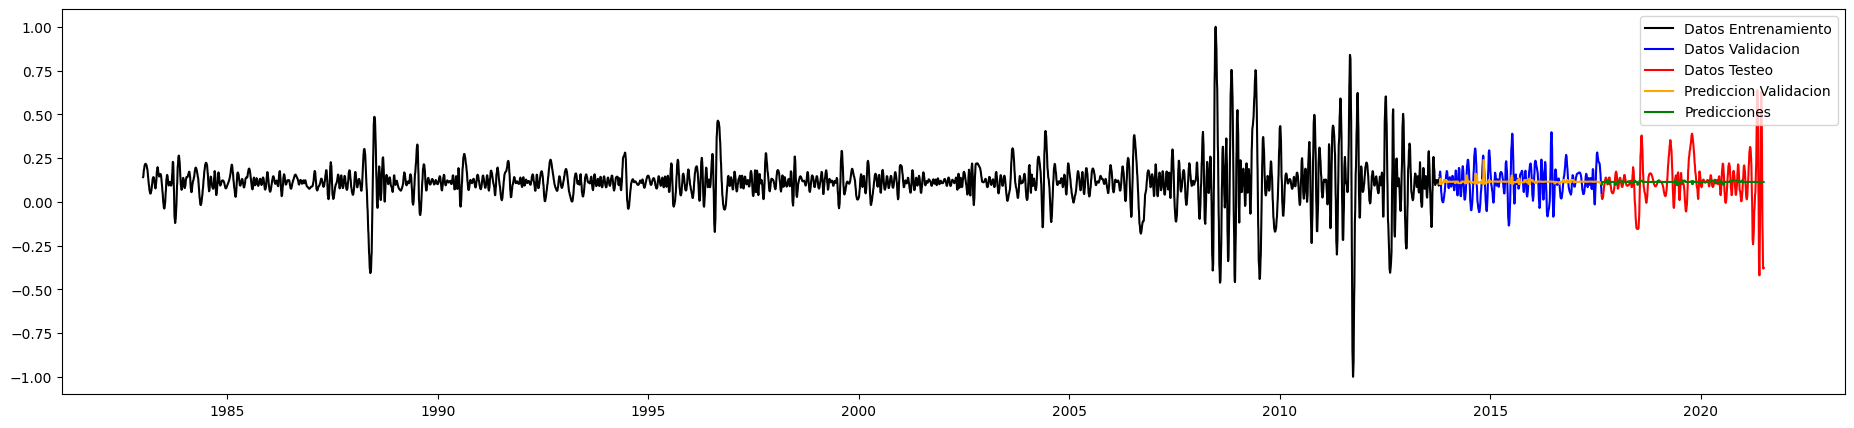

In [50]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion.index,validacion_modo_3,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo.index,prediccion_modo_3,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [51]:
validacion_modo_3 = modo_3_scaler.inverse_transform(validacion_modo_3.reshape(-1, 1))
prediccion_modo_3 = modo_3_scaler.inverse_transform(prediccion_modo_3.reshape(-1, 1))

In [52]:
prediccion_modo_3.shape

(1406, 1)

# modelaremos el modo 4

In [53]:
modo_4 = modo_4.asfreq('D')
modo_4.interpolate(inplace=True)

In [54]:
modo_4_values = modo_4.values
modo_4_values = modo_4_values.astype('float32')
modo_4_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_4_values = modo_4_values.reshape(-1, 1)
modo_4_escalado =  pd.DataFrame(modo_4_scaler.fit_transform(modo_4_values), columns=modo_4.columns,index=modo_4.index)
modo_4_escalado.head()

,Precio_Cierre
Fecha,
1980-01-02,-0.039828
1980-01-03,-0.046625
1980-01-04,-0.052982
1980-01-05,-0.054141
1980-01-06,-0.055300


In [55]:
modo_4_sup = create_features(modo_4_escalado)
modo_4_sup = add_lags(modo_4_sup)
modo_4_sup.dropna(inplace=True)
modo_4_sup.tail()

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
2021-06-25,-0.216465,4,2,6,2021,176,25,25,0.055907,0.280513,-0.138300
2021-06-26,-0.220940,5,2,6,2021,177,26,25,0.048567,0.273636,-0.149971
2021-06-27,-0.225415,6,2,6,2021,178,27,25,0.045956,0.266984,-0.161250
2021-06-28,-0.229891,0,2,6,2021,179,28,26,0.043345,0.264950,-0.172076
2021-06-29,-0.243037,1,2,6,2021,180,29,26,0.040734,0.262917,-0.175513


In [56]:
modo_4= pd.DataFrame(modo_4_scaler.inverse_transform(modo_4_sup),columns=modo_4_sup.columns,index=modo_4_sup.index)

In [57]:
total_datos=len(modo_4_sup.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = modo_4_sup[:division_entrenamiento]
datos_validacion = modo_4_sup[division_entrenamiento:division_validacion]
datos_testeo = modo_4_sup[division_validacion:total_datos]

In [58]:
total_datos=len(modo_4_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m4 = modo_4_sup[:division_entrenamiento]
datos_validacion_m4 = modo_4_sup[division_entrenamiento:division_validacion]
datos_testeo_m4 = modo_4_sup[division_validacion:total_datos]

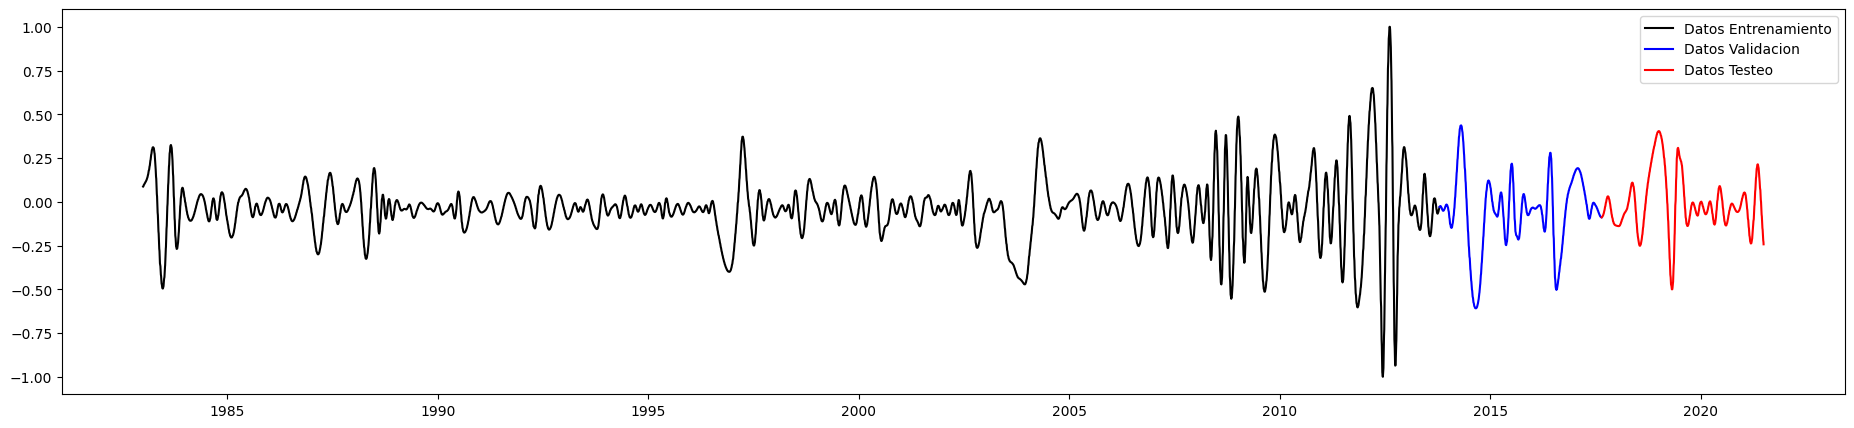

In [59]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [60]:
ajuste_modelo(datos_entrenamiento_m4,datos_testeo_m4)

El número más pequeño en la posición 3 de las tuplas es: 0.117471255
El índice de la tupla con el número más pequeño es: 5
el learning rate es 0.01 el max_depth es 3 y el subsample es 1.0


In [61]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
modo_4_sup = modo_4_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_4_sup[:division_validacion]) :
    train = modo_4_sup.iloc[train_idx]
    test = modo_4_sup.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                          # Objective= 'reg:squarederror' ,
                           max_depth= 2 ,
                           learning_rate= 0.2,
                            subsample=0.8)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_modo_4 = reg.predict(X_test)
    validacion_modo_4 = pd.Series(validacion_modo_4)
    preds.append(validacion_modo_4)
    score = np.sqrt(mean_squared_error(validacion_modo_4,y_test))
    mae = mean_absolute_error(validacion_modo_4,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_4,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_4 = reg.predict(datos_validacion[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:0.17237	validation_1-rmse:0.23449
[49]	validation_0-rmse:0.14477	validation_1-rmse:0.29941
[0]	validation_0-rmse:0.17486	validation_1-rmse:0.18414
[65]	validation_0-rmse:0.14618	validation_1-rmse:0.17663
[0]	validation_0-rmse:0.17525	validation_1-rmse:0.14638
[52]	validation_0-rmse:0.14882	validation_1-rmse:0.15660
Puntuación entre pliegues 0.17748336493968964 
Puntuaciones plegar: [0.23448561, 0.16740255, 0.13056195] 
Error Absoluto medio entre pliegues 0.13361026346683502
porcentaje de error absoluto medio entre pliegues 5.904989242553711


In [62]:
X_train=modo_4_sup[CARACTERISTICAS][:division_validacion]
y_train = modo_4_sup[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


prediccion_modo_4 = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],prediccion_modo_4))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:0.17437	validation_1-rmse:0.13919
[100]	validation_0-rmse:0.13981	validation_1-rmse:0.08437
[200]	validation_0-rmse:0.12873	validation_1-rmse:0.07203
[284]	validation_0-rmse:0.12227	validation_1-rmse:0.07119
El error Cuadratico medio del modelo es 0.18967744708061218


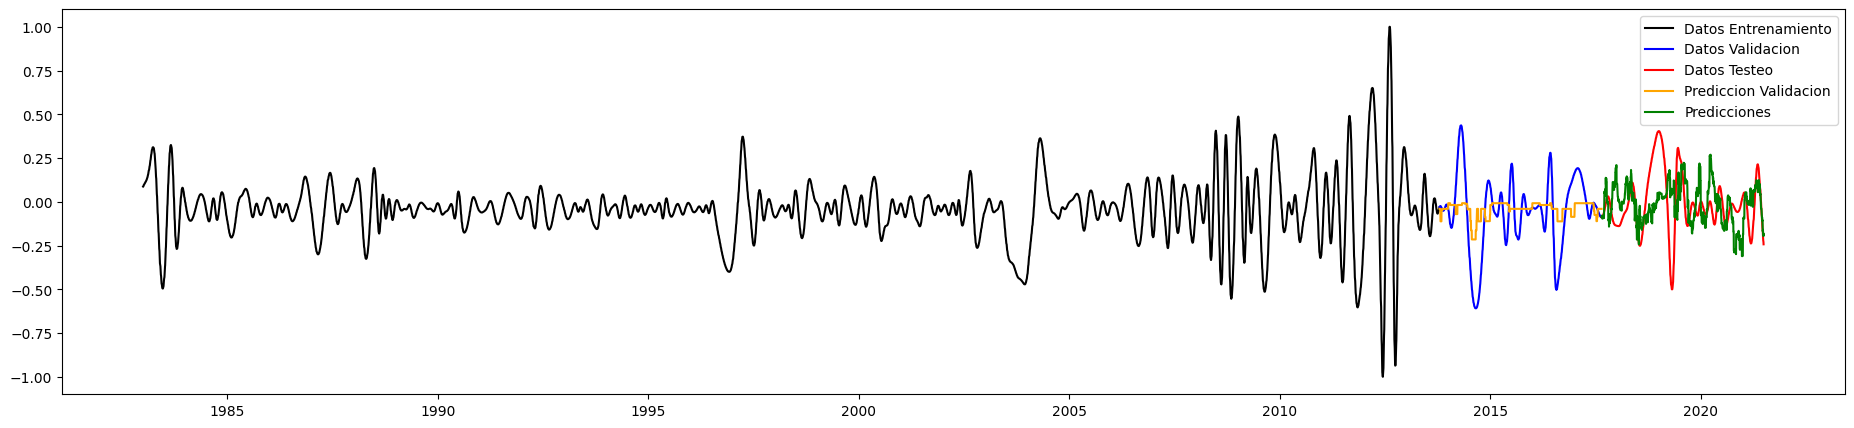

In [63]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_m4.index,validacion_modo_4,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo.index,prediccion_modo_4,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [64]:
validacion_modo_4 = modo_4_scaler.inverse_transform(validacion_modo_4.reshape(-1, 1))
prediccion_modo_4 = modo_4_scaler.inverse_transform(prediccion_modo_4.reshape(-1, 1))

# modelaremos el modo 5

In [65]:
modo_5 = modo_5.asfreq('D')
modo_5.interpolate(inplace=True)

In [66]:
modo_5_values = modo_5.values
modo_5_values = modo_5_values.astype('float32')
modo_5_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_5_values = modo_5_values.reshape(-1, 1)
modo_5_escalado =  pd.DataFrame(modo_5_scaler.fit_transform(modo_5_values), columns=modo_5.columns,index=modo_5.index)
modo_5_escalado.head()

,Precio_Cierre
Fecha,
1980-01-02,0.106591
1980-01-03,0.104982
1980-01-04,0.103360
1980-01-05,0.103032
1980-01-06,0.102705


In [67]:
modo_5_sup = create_features(modo_5_escalado)
modo_5_sup = add_lags(modo_5_sup)
modo_5_sup.dropna(inplace=True)
modo_5_sup.tail()

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
2021-06-25,0.109540,4,2,6,2021,176,25,25,-0.026094,0.170208,0.167857
2021-06-26,0.109609,5,2,6,2021,177,26,25,-0.024708,0.168378,0.165665
2021-06-27,0.109677,6,2,6,2021,178,27,25,-0.024242,0.166340,0.163404
2021-06-28,0.109745,0,2,6,2021,179,28,26,-0.023776,0.165594,0.161076
2021-06-29,0.109883,1,2,6,2021,180,29,26,-0.023310,0.164848,0.160278


In [68]:
modo_5= pd.DataFrame(modo_5_scaler.inverse_transform(modo_5_sup),columns=modo_5_sup.columns,index=modo_5_sup.index)

In [69]:
total_datos=len(modo_5_sup.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = modo_5_sup[:division_entrenamiento]
datos_validacion = modo_5_sup[division_entrenamiento:division_validacion]
datos_testeo = modo_5_sup[division_validacion:total_datos]

In [70]:
total_datos=len(modo_5_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m5 = modo_5_sup[:division_entrenamiento]
datos_validacion_m5 = modo_5_sup[division_entrenamiento:division_validacion]
datos_testeo_m5 = modo_5_sup[division_validacion:total_datos]

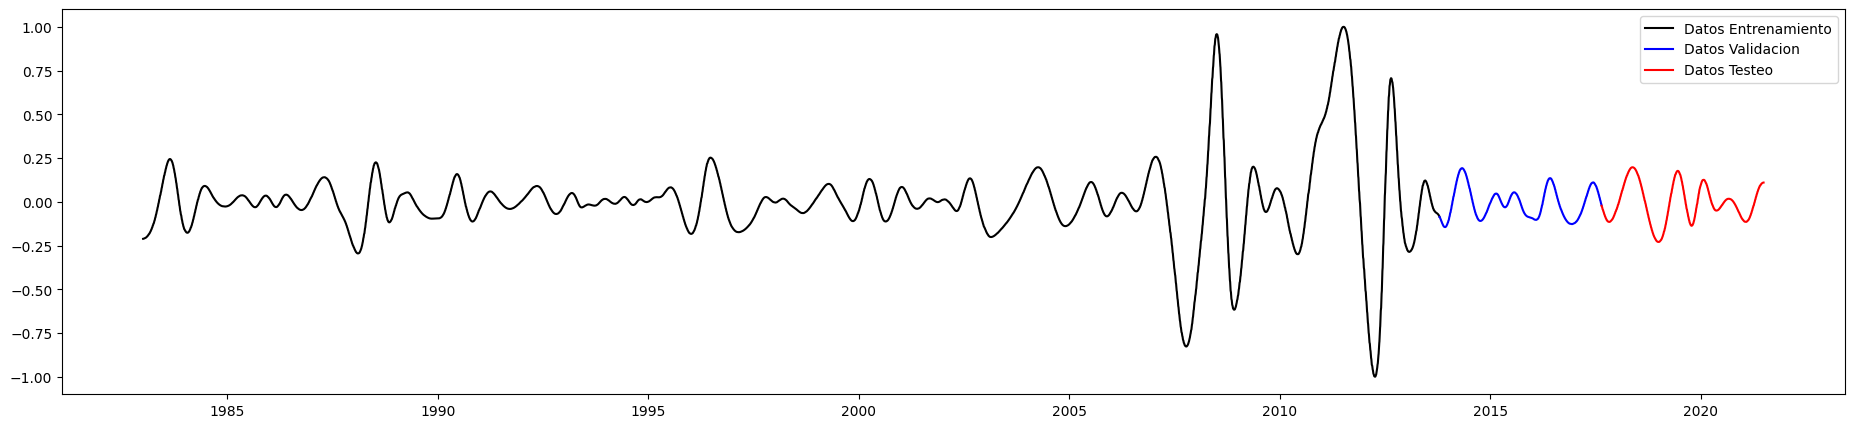

In [71]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [72]:
ajuste_modelo(datos_entrenamiento_m5,datos_testeo_m5)

El número más pequeño en la posición 3 de las tuplas es: 0.08422786
El índice de la tupla con el número más pequeño es: 42
el learning rate es 0.2 el max_depth es 2 y el subsample es 0.8


In [73]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
modo_5_sup = modo_5_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_5_sup[:division_validacion]) :
    train = modo_5_sup.iloc[train_idx]
    test = modo_5_sup.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                          # Objective= 'reg:squarederror' ,
                           max_depth= 2 ,
                           learning_rate= 0.2,
                            subsample=0.8)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_modo_5 = reg.predict(X_test)
    validacion_modo_5 = pd.Series(validacion_modo_5)
    preds.append(validacion_modo_5)
    score = np.sqrt(mean_squared_error(validacion_modo_5,y_test))
    mae = mean_absolute_error(validacion_modo_5,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_5,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_5 = reg.predict(datos_validacion[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:0.22797	validation_1-rmse:0.06160
[49]	validation_0-rmse:0.13853	validation_1-rmse:0.11622
[0]	validation_0-rmse:0.22513	validation_1-rmse:0.08121
[57]	validation_0-rmse:0.13243	validation_1-rmse:0.09578
[0]	validation_0-rmse:0.22201	validation_1-rmse:0.08993
[100]	validation_0-rmse:0.11281	validation_1-rmse:0.06469
[200]	validation_0-rmse:0.08930	validation_1-rmse:0.03934
[215]	validation_0-rmse:0.08732	validation_1-rmse:0.03652
Puntuación entre pliegues 0.05527932941913605 
Puntuaciones plegar: [0.061598532, 0.06998098, 0.03425847] 
Error Absoluto medio entre pliegues 0.04803952947258949
porcentaje de error absoluto medio entre pliegues 14.757251739501953


In [74]:
CARACTERISTICAS =[ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
OBJETIVO = 'Precio_Cierre'

X_train=modo_5_sup[CARACTERISTICAS][:division_validacion]
y_train = modo_5_sup[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


prediccion_modo_5 = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],prediccion_modo_5))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:0.21961	validation_1-rmse:0.08702
[100]	validation_0-rmse:0.11334	validation_1-rmse:0.02891
[165]	validation_0-rmse:0.09755	validation_1-rmse:0.02826
El error Cuadratico medio del modelo es 0.09070654213428497


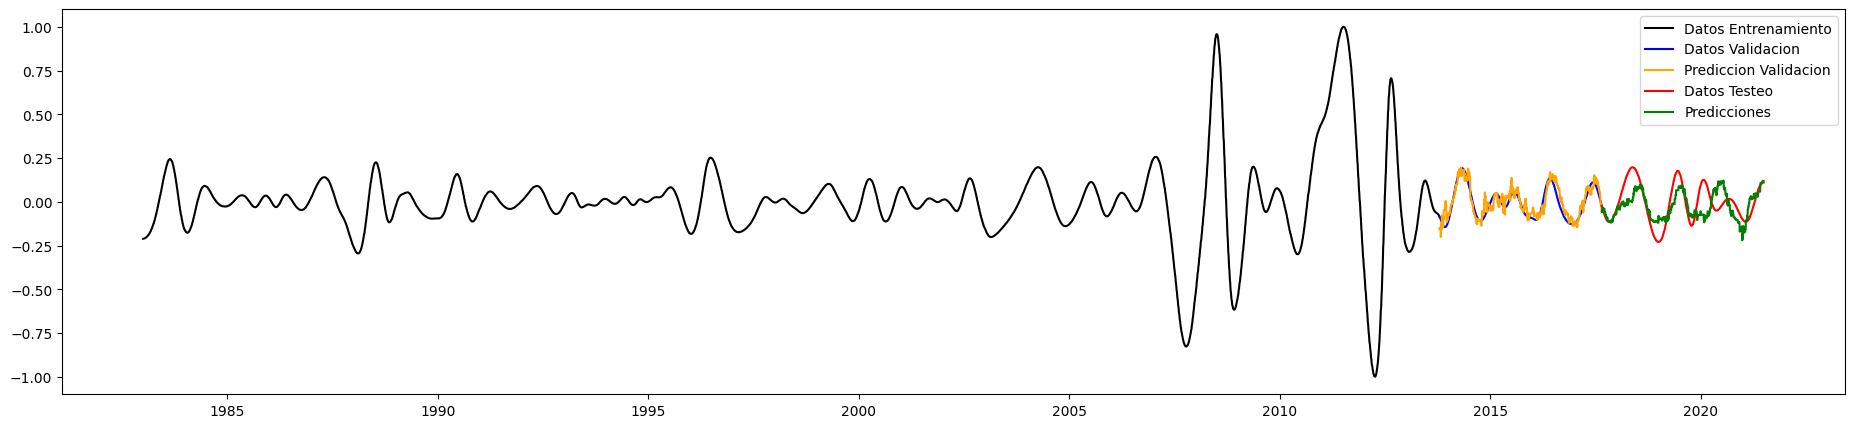

In [75]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion.index,validacion_modo_5,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,prediccion_modo_5,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [76]:
validacion_modo_5 = modo_5_scaler.inverse_transform(validacion_modo_5.reshape(-1, 1))
prediccion_modo_5 = modo_5_scaler.inverse_transform(prediccion_modo_5.reshape(-1, 1))

# Modelaremos el residuo

In [77]:
residuo = residuo.asfreq('D')
residuo.interpolate(inplace=True)

In [78]:
residuo_values = residuo.values
residuo_values = residuo_values.astype('float32')
residuo_scaler = MinMaxScaler(feature_range=(-1, 1))
residuo_values = residuo_values.reshape(-1, 1)
residuo_escalado =  pd.DataFrame(residuo_scaler.fit_transform(residuo_values), columns=residuo.columns,index=residuo.index)
residuo_escalado.head()

,Precio_Cierre
Fecha,
1980-01-02,-0.500525
1980-01-03,-0.499712
1980-01-04,-0.498891
1980-01-05,-0.498725
1980-01-06,-0.498560


In [79]:
residuo_sup = create_features(residuo_escalado)
residuo_sup = add_lags(residuo_sup)
residuo_sup.dropna(inplace=True)
residuo_sup.tail()

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
2021-06-25,0.626835,4,2,6,2021,176,25,25,-0.253228,-0.022898,-0.123106
2021-06-26,0.628052,5,2,6,2021,177,26,25,-0.252767,-0.022883,-0.123113
2021-06-27,0.629269,6,2,6,2021,178,27,25,-0.252603,-0.022880,-0.123116
2021-06-28,0.630486,0,2,6,2021,179,28,26,-0.252438,-0.022884,-0.123114
2021-06-29,0.634110,1,2,6,2021,180,29,26,-0.252274,-0.022888,-0.123112


In [80]:
residuo= pd.DataFrame(residuo_scaler.inverse_transform(residuo_sup),columns=residuo_sup.columns,index=residuo_sup.index)

In [81]:
total_datos=len(residuo_sup.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = residuo_sup[:division_entrenamiento]
datos_validacion = residuo_sup[division_entrenamiento:division_validacion]
datos_testeo = residuo_sup[division_validacion:total_datos]

In [82]:
total_datos=len(residuo_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_residuo = residuo_sup[:division_entrenamiento]
datos_validacion_residuo = residuo_sup[division_entrenamiento:division_validacion]
datos_testeo_residuo = residuo_sup[division_validacion:total_datos]

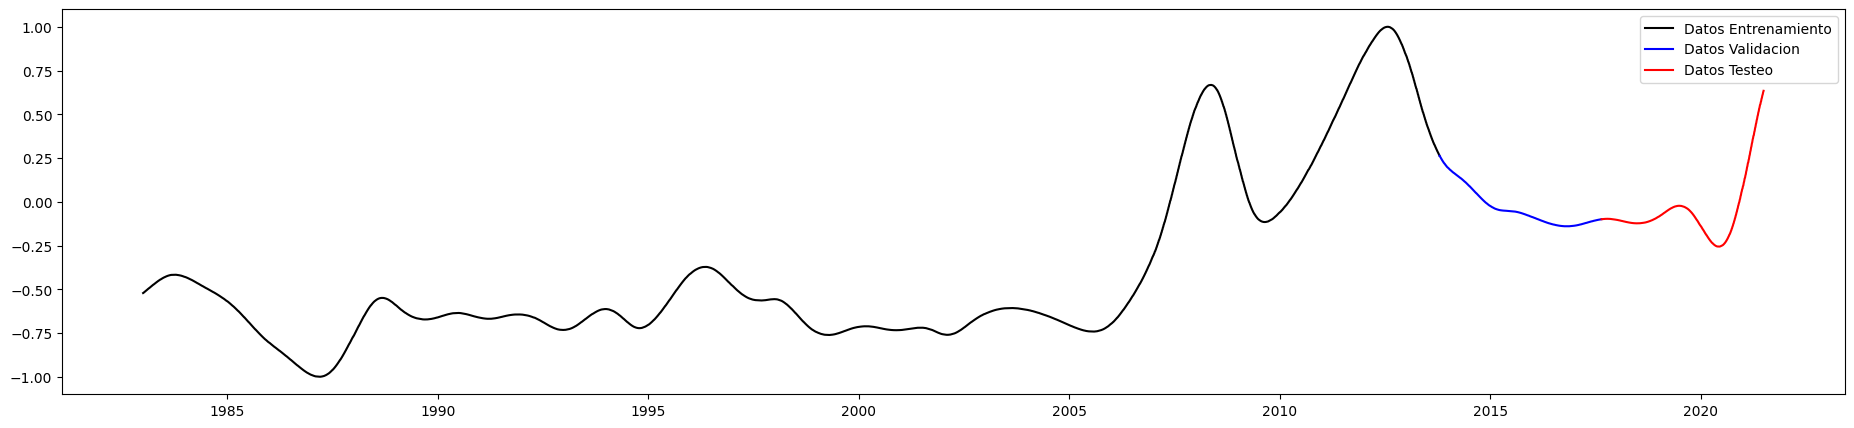

In [83]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [84]:
ajuste_modelo(datos_entrenamiento_residuo,datos_testeo_residuo)

El número más pequeño en la posición 3 de las tuplas es: 0.11182261
El índice de la tupla con el número más pequeño es: 24
el learning rate es 0.1 el max_depth es 3 y el subsample es 0.8


In [85]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
residuo_sup = residuo_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(residuo_sup[:division_validacion]) :
    train = residuo_sup.iloc[train_idx]
    test = residuo_sup.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 3 ,
                           learning_rate= 0.1,
                            subsample=0.8)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_residuo = reg.predict(X_test)
    validacion_residuo = pd.Series(validacion_residuo)
    preds.append(validacion_residuo)
    score = np.sqrt(mean_squared_error(validacion_residuo,y_test))
    mae = mean_absolute_error(validacion_residuo,y_test)
    mape = mean_absolute_percentage_error(validacion_residuo,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_residuo = reg.predict(datos_validacion[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:0.43616	validation_1-rmse:0.30625
[55]	validation_0-rmse:0.04538	validation_1-rmse:0.31263
[0]	validation_0-rmse:0.43489	validation_1-rmse:0.18120
[52]	validation_0-rmse:0.05562	validation_1-rmse:0.65810
[0]	validation_0-rmse:0.43124	validation_1-rmse:0.22900
[59]	validation_0-rmse:0.05008	validation_1-rmse:0.12568
Puntuación entre pliegues 0.05706184729933739 
Puntuaciones plegar: [0.11784847, 0.039660376, 0.013676685] 
Error Absoluto medio entre pliegues 0.05122743919491768
porcentaje de error absoluto medio entre pliegues 0.5716108083724976


In [86]:
CARACTERISTICAS =[ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
OBJETIVO = 'Precio_Cierre'

X_train=residuo_sup[CARACTERISTICAS][:division_validacion]
y_train = residuo_sup[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
prediccion_residuo = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],prediccion_residuo))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:0.42677	validation_1-rmse:0.22427
[62]	validation_0-rmse:0.04865	validation_1-rmse:0.02383
El error Cuadratico medio del modelo es 0.18750034272670746


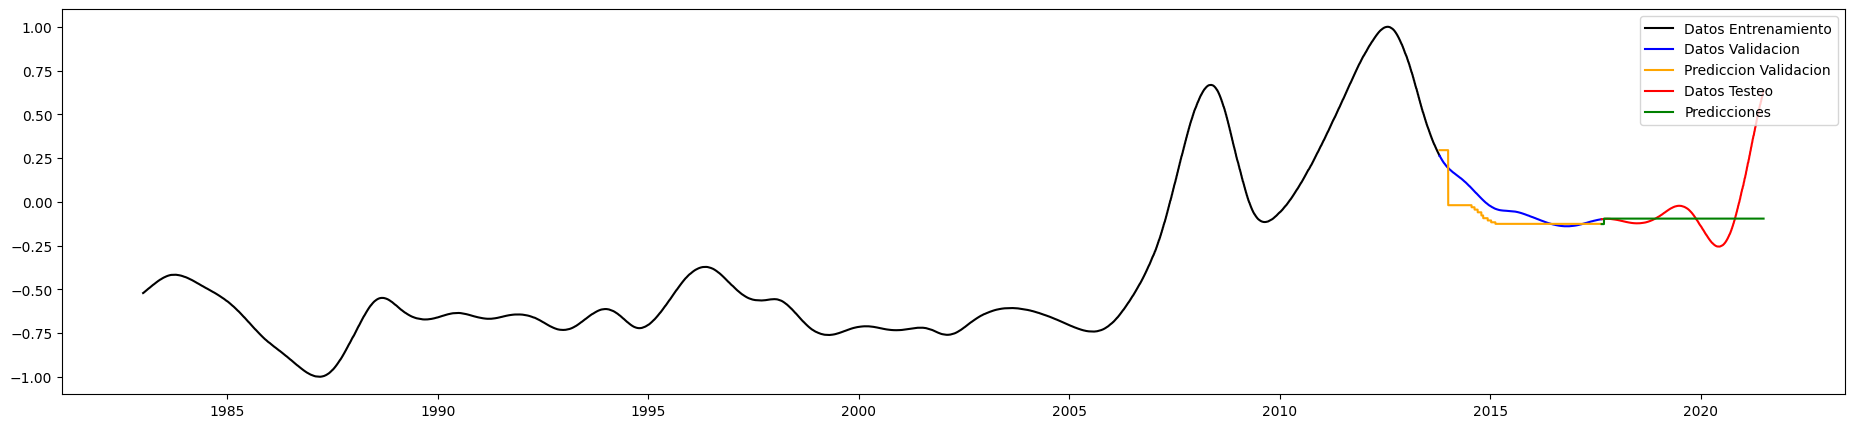

In [87]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion.index,validacion_residuo,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,prediccion_residuo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [88]:
validacion_residuo = residuo_scaler.inverse_transform(validacion_residuo.reshape(-1, 1))
prediccion_residuo = residuo_scaler.inverse_transform(prediccion_residuo.reshape(-1, 1))

# Ensemble
vamos a hacer el ensemble de todos los modelos para obtener el modelo final

In [89]:
datos_emd.shape

(15155, 1)

In [90]:
validacion_modo_1 + validacion_modo_2 + validacion_modo_3 + validacion_modo_4 + validacion_modo_5 + validacion_residuo

array([[469.73462],
       [470.23013],
       [471.2669 ],
       ...,
       [385.73602],
       [383.05032],
       [382.54086]], dtype=float32)

In [91]:
datos_emd = modo_1.Precio_Cierre + modo_2.Precio_Cierre +modo_3.Precio_Cierre + modo_4.Precio_Cierre + modo_5.Precio_Cierre + residuo.Precio_Cierre
predicciones_emd = prediccion_modo_1 + prediccion_modo_2 + prediccion_modo_3 + prediccion_modo_4 + prediccion_modo_5+ prediccion_residuo
datos_emd = datos_emd.to_frame()

In [92]:
total_datos=len(datos_emd.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_validacion = datos_emd[division_entrenamiento:division_validacion]
datos_testeo = datos_emd[division_validacion:total_datos]

In [93]:
validacion = validacion_modo_1 + validacion_modo_2 + validacion_modo_3 +  validacion_modo_4 + validacion_modo_5 + validacion_residuo
validacion

array([[469.73462],
       [470.23013],
       [471.2669 ],
       ...,
       [385.73602],
       [383.05032],
       [382.54086]], dtype=float32)

Metricas validacion

In [99]:
validacion = validacion_modo_1 + validacion_modo_2 + validacion_modo_3 +  validacion_modo_4 + validacion_modo_5 + validacion_residuo
recm_validacion = np.sqrt(mean_squared_error( validacion,datos_validacion.Precio_Cierre))
eam_validacion = mean_absolute_error( validacion,datos_validacion.Precio_Cierre)
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion.Precio_Cierre)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm_validacion} ' )
print ( f'el error absoluto medio del modelo es: {eam_validacion} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion}")

La raiz del error cuadratico medio del modelo es: 25.600316018434576 
el error absoluto medio del modelo es: 18.83703404122884 
Error porcentual absoluto medio del modelo es: 0.046039069829498125


Metricas de testeo del modelo

In [95]:
recm = np.sqrt(mean_squared_error( predicciones_emd,datos_testeo.Precio_Cierre))
eam = mean_absolute_error( predicciones_emd,datos_testeo.Precio_Cierre)
EPAM = mean_absolute_percentage_error(predicciones_emd,datos_testeo.Precio_Cierre)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm} ' )
print ( f'el error absoluto medio del modelo es: {eam} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM}")

La raiz del error cuadratico medio del modelo es: 48.9735336793539 
el error absoluto medio del modelo es: 30.97319154766091 
Error porcentual absoluto medio del modelo es: 0.07761235349243804


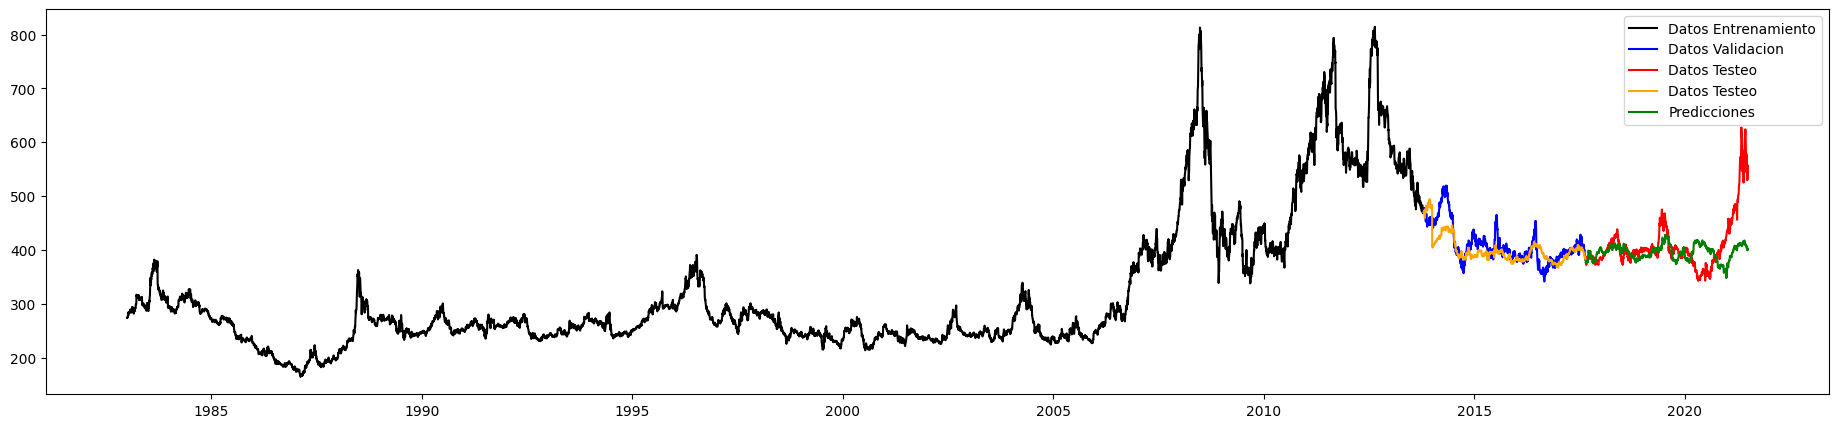

In [96]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion.index,validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo.index,predicciones_emd,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

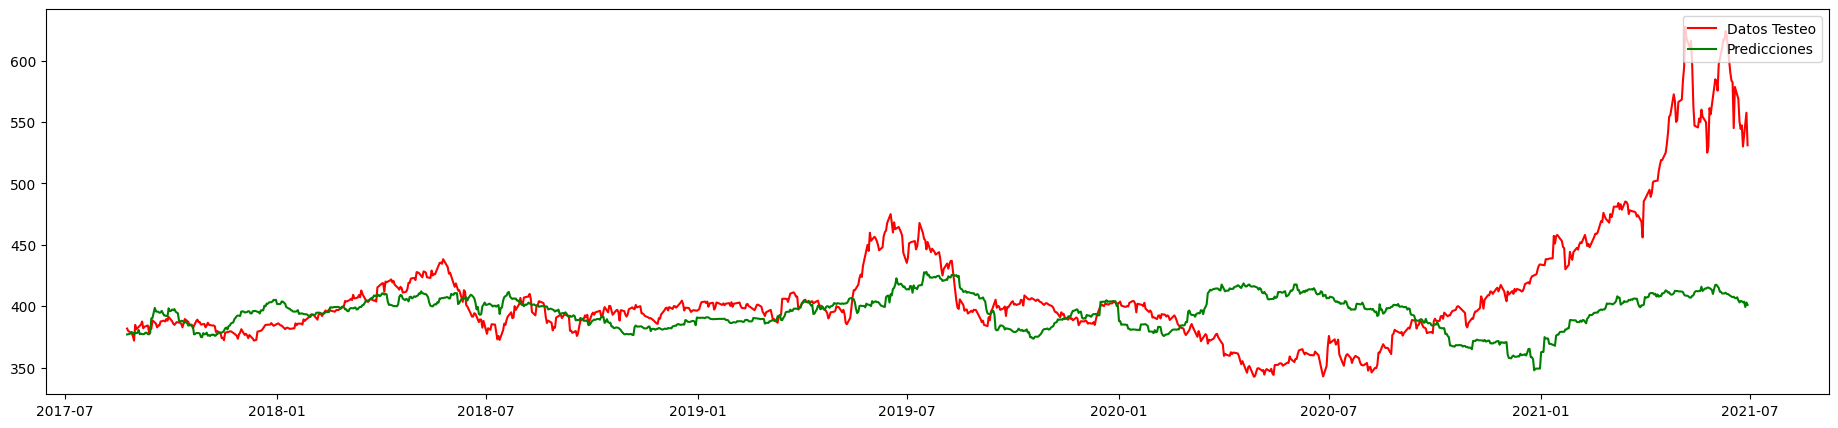

In [97]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,predicciones_emd,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()